# CNN 구현

시계열 데이터의 패턴을 학습하여 타겟 1개를 예측

* 데이터: Champagne_Sales.csv
* input: 현재와 과거 12개월동안의 판매량
* output: 다음달 판매량

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [44]:
'''
univariate lstm example
'''
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import plot_model

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Champagne_Sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

<Figure size 432x288 with 0 Axes>

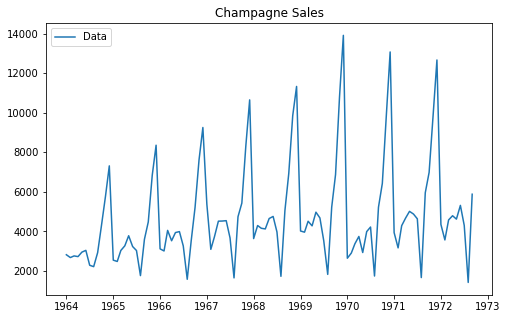

In [4]:
'''
데이터 시각화
'''
plt.clf()
plt.figure(figsize = (8, 5))
plt.title('Champagne Sales')
plt.plot(original_data_df, label = 'Data')
plt.legend(loc = 'upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

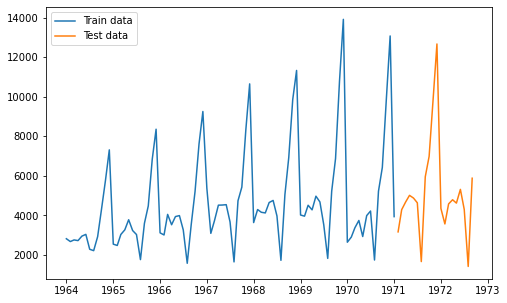

In [5]:
'''
분리된 데이터 및 시각화
'''
time_steps = 12

train_data_df = original_data_df[:85]
test_data_df = original_data_df[-20:]

plt.clf()
plt.figure(figsize = (8, 5))
plt.plot(train_data_df, label = 'Train data')
plt.plot(test_data_df, label = 'Test data')
plt.legend(loc = 'upper left')
plt.show()

In [6]:
'''
학습 데이터셋 함수 정의

sequence를 학습에 사용할 데이터로 변환

입력 데이터는 sequence에서 sequence_length 단위로 분리하여 구성

출력 데이터는 입력 데이터 다음 순서에 오는 값으로 구성
'''

def split_sequence(sequence, time_steps):
    x_train_input_list, y_train_output_list = list(), list()
    
    for index in range(len(sequence)):
        end_index = index + time_steps
        
        if end_index > len(sequence) - 1:
            break
            
        sequence_x_train, sequence_y_train = sequence[index: end_index], sequence[end_index]
        x_train_input_list.append(sequence_x_train)
        y_train_output_list.append(sequence_y_train)
        
    return np.array(x_train_input_list), np.array(y_train_output_list)

In [17]:
'''
train, test 데이터 분리
'''
train_data_df = original_data_df[:85]
test_data_df = original_data_df[-(20 + time_steps):]

In [18]:
'''
input, output 분리
'''
x_train_data_np, y_train_data_np = split_sequence(train_data_df, time_steps)
x_test_data_np, y_test_data_np = split_sequence(test_data_df, time_steps)

In [19]:
'''
데이터 reshape

[samples, time_steps] -> [samples, time_steps, num_features]
'''
num_features = 1
x_train_data_np = x_train_data_np.reshape((x_train_data_np.shape[0], x_train_data_np.shape[1], num_features))
x_test_data_np = x_test_data_np.reshape((x_test_data_np.shape[0], x_test_data_np.shape[1], num_features))

In [20]:
y_train_data_np.shape

(73,)

In [22]:
'''
train, test 데이터 구성
'''
print("x_train: ", x_train_data_np.shape)
print(x_train_data_np[:2])
print("y_train: ", y_train_data_np.shape)
print(y_train_data_np[:2])
print("-----------------")
print("x_test: ", x_test_data_np.shape)
print(x_test_data_np[:2])
print("y_test: ", y_test_data_np.shape)
print(y_test_data_np[:2])

x_train:  (73, 12, 1)
[[[2815]
  [2672]
  [2755]
  [2721]
  [2946]
  [3036]
  [2282]
  [2212]
  [2922]
  [4301]
  [5764]
  [7312]]

 [[2672]
  [2755]
  [2721]
  [2946]
  [3036]
  [2282]
  [2212]
  [2922]
  [4301]
  [5764]
  [7312]
  [2541]]]
y_train:  (73,)
[2541 2475]
-----------------
x_test:  (20, 12, 1)
[[[ 2899]
  [ 3370]
  [ 3740]
  [ 2927]
  [ 3986]
  [ 4217]
  [ 1738]
  [ 5221]
  [ 6424]
  [ 9842]
  [13076]
  [ 3934]]

 [[ 3370]
  [ 3740]
  [ 2927]
  [ 3986]
  [ 4217]
  [ 1738]
  [ 5221]
  [ 6424]
  [ 9842]
  [13076]
  [ 3934]
  [ 3162]]]
y_test:  (20,)
[3162 4286]


In [23]:
'''
모델 설계
'''
model = Sequential()
model.add(Conv1D(128, 2, activation = 'relu', input_shape = (time_steps, num_features)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [24]:
'''
학습
'''
learning_log = model.fit(
    x_train_data_np, 
    y_train_data_np, 
    epochs = 1000, 
    validation_data = (
        x_test_data_np, 
        y_test_data_np
    ), 
    verbose = 0
)

Epochs : 1000


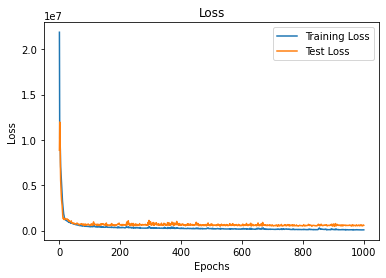

In [32]:
'''
loss 정의
'''
train_loss = learning_log.history['loss']
val_loss = learning_log.history['val_loss']

epochs = range(1, len(train_loss) + 1)
print('Epochs : %d' % len(epochs))

'''
train loss 출력
'''
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

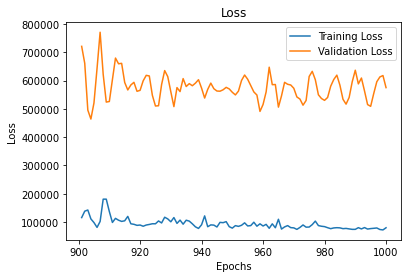

In [33]:
'''
Loss 마지막 부분 확대 출력
'''

last_epochs = 100
plt.clf()
plt.plot(epochs[-last_epochs:], loss[-last_epochs:], label = 'Training Loss')
plt.plot(epochs[-last_epochs:], val_loss[-last_epochs:], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
'''
평가
'''
prediction = model.predict(
    x_test_data_np, 
    verbose = 0
)

In [39]:
y_diff = list(y_test_data_np[index] - prediction[index] for index in range(len(y_test_data_np)))

In [40]:
y_diff

[array([-309.2517], dtype=float32),
 array([1552.5054], dtype=float32),
 array([953.959], dtype=float32),
 array([1403.9124], dtype=float32),
 array([54.19287], dtype=float32),
 array([115.762695], dtype=float32),
 array([523.9811], dtype=float32),
 array([899.5581], dtype=float32),
 array([-46.643555], dtype=float32),
 array([-923.38574], dtype=float32),
 array([-1654.8838], dtype=float32),
 array([437.31274], dtype=float32),
 array([-972.6924], dtype=float32),
 array([-380.73145], dtype=float32),
 array([238.78467], dtype=float32),
 array([-49.705566], dtype=float32),
 array([-37.35254], dtype=float32),
 array([-207.01123], dtype=float32),
 array([-26.3031], dtype=float32),
 array([184.50488], dtype=float32)]

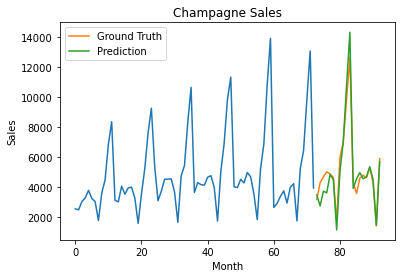

In [43]:
'''
평가 데이터 시각화
'''
y_train_xticks = list(index for index in range(len(y_train_data_np)))
plt.plot(y_train_xticks, y_train_data_np)

y_test_xticks = list(len(y_train_data_np) + index for index in range(len(y_test_data_np)))

plt.plot(y_test_xticks, y_test_data_np, label = 'Ground Truth')
plt.plot(y_test_xticks, prediction, label = 'Prediction')
plt.title('Champagne Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [46]:
'''
ARIMA와 비교
'''
rmse = sqrt(mean_squared_error(y_test_data_np, prediction))
r2_score_ret = r2_score(y_test_data_np, prediction)
print("RMSE: {:.3f}".format(rmse))
print("R2 Score: {:.5f}".format(r2_score_ret))

RMSE: 758.330
R2 Score: 0.90356
